In [70]:
### imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

# Instacart Customer Segmentation

This notebook performs customer segmentation using Unsupervised Machine Learning (specifically K-means).
At a high level, we will aggregate customer's shopping behaviour, then apply K-means clustering and then analyse the resulting segments.


By default, the codes below assume that the csv files are available in ./data folder
If running after downloading the codebase from GitHub, download the CSV files first from https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis

One downloaded, place all the .csv files in the "data" folder which is committed in GitHub. The below codes should then work as expected.

In [73]:
### Running locally where the data have been downloaded into ../data
# LOAD DATA
orders = pd.read_csv('./data/orders.csv')
order_products_prior = pd.read_csv('./data/order_products__prior.csv')
#order_products_train = pd.read_csv('./data/order_products__train.csv') - we won't be using this for now as this is more relevant for product prediction
products = pd.read_csv('./data/products.csv')
aisles = pd.read_csv('./data/aisles.csv')
departments = pd.read_csv('./data/departments.csv')


## 1. Examining the data

In this section, we'll try and get familiarised with the data

### Orders

In [77]:
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Orders Products (Prior)

In [80]:
print(order_products_prior.shape)
order_products_prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Products

In [83]:
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Aisles

In [86]:
print(aisles.shape)
aisles.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Departments

In [89]:
print(departments.shape)
departments.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## 2. Check and Correct Data Quality Issue Where Applicable
Check if there are any data quality issues and correct/mitigate where appropriate.
If anomalies/outliers are seen but not corrected or excluded, justification will be provided below.

### Check for Missing Values

In [93]:
for name, df in {
    "orders": orders,
    "order_products__prior": order_products_prior,
    "products": products,
    "departments": departments,
    "aisles": aisles
}.items():
    print(f"\n{name} missing values:\n", df.isnull().sum())


orders missing values:
 order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

order_products__prior missing values:
 order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

products missing values:
 product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

departments missing values:
 department_id    0
department       0
dtype: int64

aisles missing values:
 aisle_id    0
aisle       0
dtype: int64


#### Observations on Missing Values check:

- It seems that the data is pretty clean i.e. no missing values
- The days_since_prior_order column in orders.csv has 206209 missing values, but this is expected as this means that cusomter had never ordered that product previously. As we noted above, the total order is 3421083, therefore around 6% of them are first-time orders.

### Check for Duplicates

In [97]:
for name, df in {
    "orders": orders,
    "order_products__prior": order_products_prior,
    "products": products,
    "departments": departments,
    "aisles": aisles
}.items():
    dup_count = df.duplicated().sum()
    if dup_count > 0:
        print(f"{name} has {dup_count} duplicate rows")
    else:
        print(f"{name} has no duplicate rows")

orders has no duplicate rows
order_products__prior has no duplicate rows
products has no duplicate rows
departments has no duplicate rows
aisles has no duplicate rows


### Check integrity of foreign keys:

#### All products in order_products_prior should be in products

In [101]:
missing_products = ~order_products_prior['product_id'].isin(products['product_id'])
print("Missing product IDs in products.csv:", missing_products.sum())

Missing product IDs in products.csv: 0


#### All orders in order_products_prior should be in orders

In [104]:
missing_orders = ~order_products_prior['order_id'].isin(orders['order_id'])
print("Missing order IDs:", missing_orders.sum())

Missing order IDs: 0


### Check for any anomalies/outlier e.g. any particular customers whose orders are much higher than others

count    206209.000000
mean         15.590367
std          16.654774
min           3.000000
25%           5.000000
50%           9.000000
75%          19.000000
max          99.000000
Name: order_id, dtype: float64


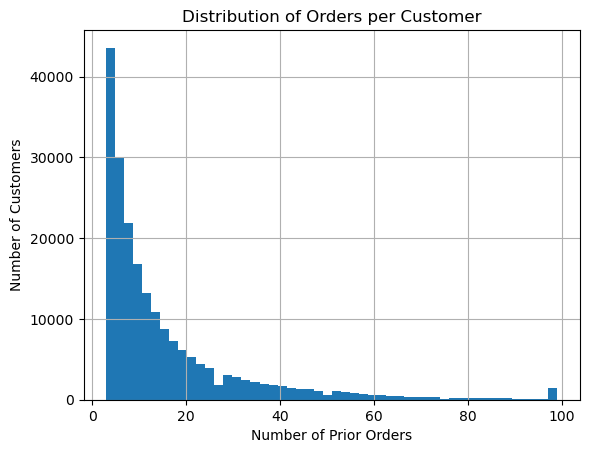

In [107]:
order_counts = orders[orders['eval_set'] == 'prior'].groupby('user_id')['order_id'].count()
print(order_counts.describe())

import matplotlib.pyplot as plt
order_counts.hist(bins=50)
plt.title("Distribution of Orders per Customer")
plt.xlabel("Number of Prior Orders")
plt.ylabel("Number of Customers")
plt.show()

#### Observations for anomalies/outlier check:
The histogram above shows that most customers are first-time customers and it makes sense to see the number of customers falls as the number of prior orders increase. However, interesttingly there seems to be a group of customers who very frequently order (as can be seen at the right side of the histogram, where Number of Prior Orders approach 100.
Rather than counting these customers out, these could be a distinct segment of customers and therefore should be included in this segmentation exercise.

#### Conclusion for Data Quality Check and Correction

The data appear to be in a good shape and do not need any particular massaging before we can use them. They will therefore be used as is.

## 3. Features Engineering

These are the features we'll use for the clustering:
1. Total orders per customer
2. Average basket size (total products/total orders)
3. Re-order probability 
4. Departments from which customers order the most
5. Average days between orders
6. Number of unique products per customer

We will group all of these data into a single row per customer.

In [112]:
# the aim is to create one row containing all of the features above per customer

# Combine datasets
# filter only prior orders as we'll be merging with order_products_prior
prior_orders = orders[orders['eval_set'] == 'prior']

# merge with order_products
merged_data = pd.merge(order_products_prior, prior_orders[['order_id', 'user_id', 'order_number', 'days_since_prior_order']],
                       on='order_id', how='left')

# add product info
merged_data = pd.merge(merged_data, products[['product_id', 'aisle_id', 'department_id']],
                       on='product_id', how='left')

# add department info
merged_data = pd.merge(merged_data, departments, on='department_id', how='left')

# add aisle info
merged_data = pd.merge(merged_data, aisles, on='aisle_id', how='left')

In [113]:
merged_data.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,days_since_prior_order,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,3,8.0,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,3,8.0,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,3,8.0,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,3,8.0,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,3,8.0,17,13,pantry,baking ingredients
5,2,17794,6,1,202279,3,8.0,83,4,produce,fresh vegetables
6,2,40141,7,1,202279,3,8.0,105,13,pantry,doughs gelatins bake mixes
7,2,1819,8,1,202279,3,8.0,88,13,pantry,spreads
8,2,43668,9,0,202279,3,8.0,123,4,produce,packaged vegetables fruits
9,3,33754,1,1,205970,16,12.0,120,16,dairy eggs,yogurt


### Prepare features

#### Total orders

In [118]:
total_orders = orders[orders['eval_set'] == 'prior'].groupby('user_id')['order_number'].max().reset_index() 
total_orders.columns = ['user_id', 'total_orders']

total_orders.head()

,user_id,total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


### Average Basket Size
This would be calculated as total products bought divided by total orders 

In [121]:
basket_sizes = merged_data.groupby(['user_id', 'order_id']).size().groupby('user_id').mean().reset_index()
basket_sizes.columns = ['user_id', 'avg_basket_size']

basket_sizes.head()

,user_id,avg_basket_size
0,1,5.900000
1,2,13.928571
2,3,7.333333
3,4,3.600000
4,5,9.250000


### Re-order probability
This is a measure of how frequently a customer tends to re-order products

In [124]:
reorder_ratio = merged_data.groupby('user_id')['reordered'].mean().reset_index()
reorder_ratio.columns = ['user_id', 'reorder_probability']

reorder_ratio.head()

,user_id,reorder_probability
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


### Top department for customers
This is the department from which a customer orders from the most

In [127]:
top_department = (
    merged_data.groupby(['user_id', 'department'])['product_id']
    .count()
    .reset_index()
    .sort_values(['user_id', 'product_id'], ascending=[True, False])
    .drop_duplicates('user_id')
    .rename(columns={'department': 'top_department'})[['user_id', 'top_department']]
)

top_department.head()

,user_id,top_department
6,1,snacks
11,2,dairy eggs
27,3,produce
31,4,beverages
45,5,produce


### Average days between orders
This is average days_since_prior_order

In [130]:
avg_time_between_orders = orders[orders['eval_set'] == 'prior'].groupby('user_id')['days_since_prior_order'].mean().reset_index()
avg_time_between_orders.columns = ['user_id', 'avg_days_between_orders']

avg_time_between_orders.head()

,user_id,avg_days_between_orders
0,1,19.555556
1,2,15.230769
2,3,12.090909
3,4,13.750000
4,5,13.333333


### Number of unique products per customer

In [133]:
unique_products = merged_data.groupby('user_id')['product_id'].nunique().reset_index()
unique_products.columns = ['user_id', 'num_unique_products']

unique_products.head()

,user_id,num_unique_products
0,1,18
1,2,102
2,3,33
3,4,17
4,5,23


### Combine all features

In [137]:
customer_features = total_orders \
    .merge(basket_sizes, on='user_id') \
    .merge(reorder_ratio, on='user_id') \
    .merge(top_department, on='user_id') \
    .merge(avg_time_between_orders, on='user_id') \
    .merge(unique_products, on='user_id')

customer_features.head()

,user_id,total_orders,avg_basket_size,reorder_probability,top_department,avg_days_between_orders,num_unique_products
0,1,10,5.900000,0.694915,snacks,19.555556,18
1,2,14,13.928571,0.476923,dairy eggs,15.230769,102
2,3,12,7.333333,0.625000,produce,12.090909,33
3,4,5,3.600000,0.055556,beverages,13.750000,17
4,5,4,9.250000,0.378378,produce,13.333333,23


## 4. Pre-processing

Check again that none of the columns has any missing data, and for the categorical column in csutomer_features i.e. top_department, we will need to encode that.

In [140]:
customer_features.isnull().sum()

user_id                    0
total_orders               0
avg_basket_size            0
reorder_probability        0
top_department             0
avg_days_between_orders    0
num_unique_products        0
dtype: int64

In [142]:
customer_features.isna().sum()

user_id                    0
total_orders               0
avg_basket_size            0
reorder_probability        0
top_department             0
avg_days_between_orders    0
num_unique_products        0
dtype: int64

Note: there's no missing value

### Encode top_department

We will encode the categorical variable top_deparment

In [146]:
customer_features_enc = pd.get_dummies(customer_features, columns=['top_department'])

In [148]:
customer_features_enc.head()

,user_id,total_orders,avg_basket_size,reorder_probability,avg_days_between_orders,num_unique_products,top_department_alcohol,top_department_babies,top_department_bakery,top_department_beverages,...,top_department_household,top_department_international,top_department_meat seafood,top_department_missing,top_department_other,top_department_pantry,top_department_personal care,top_department_pets,top_department_produce,top_department_snacks
0,1,10,5.900000,0.694915,19.555556,18,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2,14,13.928571,0.476923,15.230769,102,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,12,7.333333,0.625000,12.090909,33,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,4,5,3.600000,0.055556,13.750000,17,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,5,4,9.250000,0.378378,13.333333,23,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


### Normalise and scale the numeric features to prepare for K-means clustering

In [151]:
scaler = StandardScaler()
scaled_cust_features = scaler.fit_transform(customer_features_enc)

# convert to df
scaled_cust_features_df = pd.DataFrame(scaled_cust_features, index = customer_features_enc.index)

scaled_cust_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-1.732042,-0.335662,-0.690978,1.238152,0.611676,-0.822308,-0.105714,-0.082648,-0.075669,-0.311920,...,-0.126127,-0.018689,-0.045552,-0.00908,-0.008809,-0.128915,-0.072459,-0.047386,-1.133340,4.008071
1,-1.732026,-0.095490,0.678255,0.210583,0.003003,0.661995,-0.105714,-0.082648,-0.075669,-0.311920,...,-0.126127,-0.018689,-0.045552,-0.00908,-0.008809,-0.128915,-0.072459,-0.047386,-1.133340,-0.249497
2,-1.732009,-0.215576,-0.446530,0.908586,-0.438904,-0.557254,-0.105714,-0.082648,-0.075669,-0.311920,...,-0.126127,-0.018689,-0.045552,-0.00908,-0.008809,-0.128915,-0.072459,-0.047386,0.882348,-0.249497
3,-1.731992,-0.635877,-1.083231,-1.775655,-0.205402,-0.839979,-0.105714,-0.082648,-0.075669,3.205949,...,-0.126127,-0.018689,-0.045552,-0.00908,-0.008809,-0.128915,-0.072459,-0.047386,-1.133340,-0.249497
4,-1.731975,-0.695920,-0.119652,-0.253936,-0.264044,-0.733957,-0.105714,-0.082648,-0.075669,-0.311920,...,-0.126127,-0.018689,-0.045552,-0.00908,-0.008809,-0.128915,-0.072459,-0.047386,0.882348,-0.249497


## 5. Hyperparameter Tuning

Here are the Hyperparameters for K-menas that we will consider and tune.

For more details, also refer to https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html 

**1. n_clusters**
This determines the number of segments we will form with the data. We'll explore the optimal number of clusters using the Elbow Method below. 

**2. init**
This represents the initialisation method.
We will use **k-means++** in this case as it is known to speed up convergence. 

**3. n_init**
This represents the number of times the K-means algorithm is run with different centroid seeds.
We'll use **20** which is slightly higher than the default of 10, as high values are known to reduce the risk of poor local optima.

**4. max_iter**
This represents the maximum iterations for a single run, to prevent infinite loops. We'll keep this at default i.e. **300** as that seems like a high number already.

**5. random_state**
We'll set this to 42 for reproducibility

## 6. Pick the Optimal Number of Clusters using the Elbow Method

As discussed in a previous module in the cloud, the Elbow Method can be used to find the optimum number of clusters, where adding more does not give any further improvement in the performance.


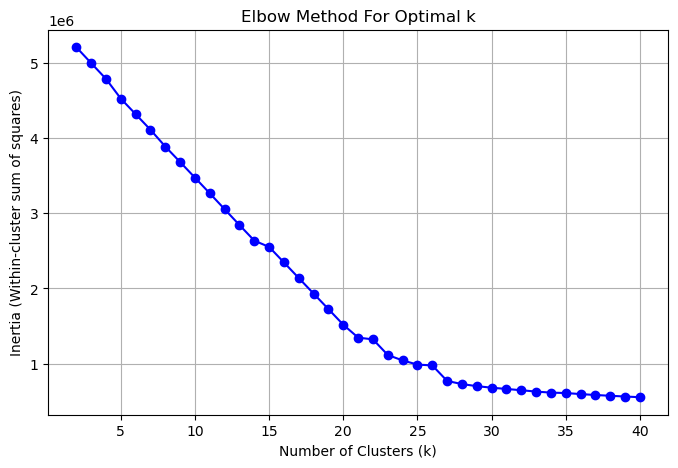

In [156]:
# Let's try between 2 and 40 clusters
K = range(2, 41)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(scaled_cust_features_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve so we can pick a reasonable k value
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

It seems that the optimal clusters in this case is **k=27**, which seems very high, but that is what the data suggests.
I will not proceed with k=27 as that might result in overfitting and in reality 27 customer segments may not provide the best business interpretation of the data. 

We'll plot one more graph to check the % change between k and k+1 to help choose a reasonable k value.

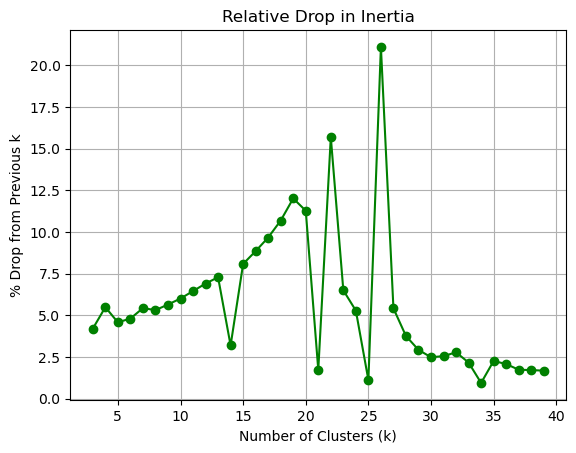

In [158]:
relative_drop = [100 * (inertia[i-1] - inertia[i]) / inertia[i-1] for i in range(1, len(inertia))]
plt.plot(range(3, 40), relative_drop[1:], 'go-')
plt.title('Relative Drop in Inertia')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('% Drop from Previous k')
plt.grid(True)
plt.show()

Unfortunately the plot above confirms the first Elbow Curve. 

However, for reason already discussed above a high number of clusters may not make the most sense, therefore for the sake of this project, we'll use **k=15**

## 7. Clustering

Now that we've determined the optimum cluster numbers i.e. k=15 and discussed the other hyperparameters above, we'll run the K-means algorithm for the clustering. 

In [160]:
kmeans = KMeans(
    n_clusters=15,         # Based on Elbow Method
    init='k-means++',      # For faster convergence
    n_init=20,             # Run multiple times to avoid poor local optima
    max_iter=300,          # Allow enough iterations to converge, but avoid infinite loops
    random_state=42        # For reproducibility
)

cluster_labels = kmeans.fit_predict(scaled_cust_features_df)

## 8. Results Analysis

### Append the cluster labels
We'll append to the unscaled/unencoded features for easier interpretation

In [163]:
customer_features['cluster'] = cluster_labels

#we'll also append to the encoded features as some of the operations we'll do for analysis are mathematical and cannot be performed on categorical fields
customer_features_enc['cluster'] = cluster_labels

In [165]:
customer_features.head()

,user_id,total_orders,avg_basket_size,reorder_probability,top_department,avg_days_between_orders,num_unique_products,cluster
0,1,10,5.900000,0.694915,snacks,19.555556,18,4
1,2,14,13.928571,0.476923,dairy eggs,15.230769,102,0
2,3,12,7.333333,0.625000,produce,12.090909,33,1
3,4,5,3.600000,0.055556,beverages,13.750000,17,7
4,5,4,9.250000,0.378378,produce,13.333333,23,1


In [167]:
customer_features.shape

(206209, 8)

### Analyse the resulting clusters

In [170]:
# Let's look at the average values - some columns i.e. average user_ids won't make sense...
# use the encoded customer_features here as the top_department in the original features is categorical.
cluster_means = customer_features_enc.groupby('cluster').mean().round(3)
cluster_means.head(20)

,user_id,total_orders,avg_basket_size,reorder_probability,avg_days_between_orders,num_unique_products,top_department_alcohol,top_department_babies,top_department_bakery,top_department_beverages,...,top_department_household,top_department_international,top_department_meat seafood,top_department_missing,top_department_other,top_department_pantry,top_department_personal care,top_department_pets,top_department_produce,top_department_snacks
cluster,,,,,,,,,,,,,,,,,,,,,
0,103451.220,12.565,9.765,0.417,15.840,55.058,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000
1,103164.911,9.327,10.325,0.376,16.711,50.420,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,1.000,0.000
2,100739.829,15.197,11.250,0.384,14.596,72.769,0.0,1.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000
3,102491.113,42.984,12.907,0.666,8.164,152.442,0.0,0.0,0.0,0.011,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.921,0.003
4,103142.576,14.625,8.873,0.454,15.532,51.641,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,1.000
5,102393.257,10.861,6.497,0.318,18.712,39.352,0.0,0.0,0.0,0.000,...,1.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000
6,104126.056,9.431,5.878,0.354,16.837,29.042,0.0,0.0,0.0,0.000,...,0.0,1.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000
7,103337.359,12.828,6.861,0.439,16.091,39.532,0.0,0.0,0.0,1.000,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000
8,107482.209,8.141,8.927,0.340,18.134,38.711,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000


In [172]:
## Look at cluster sizes
cluster_sizes = customer_features['cluster'].value_counts().sort_index()

cluster_sizes.head(20)

cluster
0     31008
1     88132
2      1399
3     30220
4     11987
5      3229
6        72
7     17940
8       561
9      1174
10     2279
11     4369
12     3371
13    10041
14      427
Name: count, dtype: int64

In [174]:
## Look at median now - which should be more robust against outliers
cluster_median = customer_features_enc.groupby('cluster').median().round(3)

cluster_median.head(20)

,user_id,total_orders,avg_basket_size,reorder_probability,avg_days_between_orders,num_unique_products,top_department_alcohol,top_department_babies,top_department_bakery,top_department_beverages,...,top_department_household,top_department_international,top_department_meat seafood,top_department_missing,top_department_other,top_department_pantry,top_department_personal care,top_department_pets,top_department_produce,top_department_snacks
cluster,,,,,,,,,,,,,,,,,,,,,
0,103894.0,9.0,8.726,0.412,15.167,44.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,103189.5,8.0,9.476,0.372,16.444,44.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100437.0,8.0,9.839,0.367,13.833,52.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101198.5,38.0,11.734,0.677,7.826,143.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,103599.0,9.0,7.333,0.455,14.938,37.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,103794.0,7.0,5.500,0.299,18.833,28.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,100439.0,6.0,5.300,0.333,17.208,20.5,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,103539.5,8.0,5.875,0.438,15.500,27.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,111356.0,5.0,7.923,0.326,18.500,29.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [176]:
# Let's find top 3 departments for each cluster... 

# Identify department columns automatically
dept_cols = [col for col in cluster_median.columns if col.startswith('top_department_')]

# Aggregate: mean of the 0/1 columns = proportion of customers in that cluster who have that department as "top"
cluster_summary = (
    cluster_median.groupby('cluster')
    .mean()
    .round(2)
)

# Find top 3 departments per cluster
top_departments_per_cluster = {}
for cluster in cluster_summary.index:
    # Sort department columns by highest proportion
    dept_scores = cluster_summary.loc[cluster, dept_cols].sort_values(ascending=False)
    top_departments_per_cluster[cluster] = list(dept_scores.head(3).index)

# Add top departments to summary table
cluster_summary['top_departments'] = cluster_summary.index.map(
    lambda c: ', '.join([d.replace('top_department_', '') for d in top_departments_per_cluster[c]])
)

# Add cluster size
cluster_sizes = customer_features['cluster'].value_counts().sort_index()
cluster_summary['cluster_size'] = cluster_sizes

#cluster_summary.head(20)
print(cluster_summary.columns)
cluster_summary.loc[:,['top_departments', 'total_orders', 'avg_basket_size', 'avg_days_between_orders', 'num_unique_products', 'cluster_size']].head(20)

Index(['user_id', 'total_orders', 'avg_basket_size', 'reorder_probability',
       'avg_days_between_orders', 'num_unique_products',
       'top_department_alcohol', 'top_department_babies',
       'top_department_bakery', 'top_department_beverages',
       'top_department_breakfast', 'top_department_bulk',
       'top_department_canned goods', 'top_department_dairy eggs',
       'top_department_deli', 'top_department_dry goods pasta',
       'top_department_frozen', 'top_department_household',
       'top_department_international', 'top_department_meat seafood',
       'top_department_missing', 'top_department_other',
       'top_department_pantry', 'top_department_personal care',
       'top_department_pets', 'top_department_produce',
       'top_department_snacks', 'top_departments', 'cluster_size'],
      dtype='object')


,top_departments,total_orders,avg_basket_size,avg_days_between_orders,num_unique_products,cluster_size
cluster,,,,,,
0,"dairy eggs, alcohol, household",9.0,8.73,15.17,44.0,31008
1,"produce, alcohol, household",8.0,9.48,16.44,44.0,88132
2,"babies, alcohol, household",8.0,9.84,13.83,52.0,1399
3,"produce, alcohol, household",38.0,11.73,7.83,143.0,30220
4,"snacks, household, produce",9.0,7.33,14.94,37.0,11987
5,"household, alcohol, produce",7.0,5.50,18.83,28.0,3229
6,"international, alcohol, household",6.0,5.30,17.21,20.5,72
7,"beverages, alcohol, household",8.0,5.88,15.50,27.0,17940
8,"dry goods pasta, alcohol, household",5.0,7.92,18.50,29.0,561


### Performance Metrics

Since we're not comparing the classification with existing labels, we will be limited to performance metrics which assess the performance of the clustering process itself. 

#### Davies-Bouldin Index ####

In this case, we'll be assessing the **Davies-Bouldin Index**, which seems to be a well-known way to evaluate clustering.

References:
- https://www.geeksforgeeks.org/machine-learning/davies-bouldin-index/
- https://codesignal.com/learn/courses/cluster-performance-unveiled/lessons/mastering-the-davies-bouldin-index-for-clustering-model-validation

In [179]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(scaled_cust_features_df, cluster_labels)

print(db_index)


1.5436994300606768


As we can see the Davies-Bouldin Index is greater than 1. This is definitely not the best results. A few references cite that a lower the Davies-Bouldin Index indicates a better clustering. 
A value greater than 1 inidcates that the clusters are not very well-separated.

I would again attribute this to perhaps having k=15, which is quite a high number of clusters. 

In future enhancement of this project, we could perhaps focus on lower k values to see if it improves the Davies-Bouldin Index.

## 9. Conclusion

Based on the above results, the K-means algorithm produced 15 distinct clusters (based on the above k=15).
Here are a few observations:

- An interesting observation is that alcohol and household departments always appear in the top 3 departments for all the clusters. This implies 2 things:
    - First, the most distinguishing difference between the clusters (aside from cluster 10 and 11 that we discussed above), is the top department.
    - Secondly, this is a very strong pattern that Instacart can exploit i.e. they can really hone down on their alcohol and household inventories and perhaps also varieties.
- At a glance, some clusters e.g. 10 and 11 look very similar to each other, both having the same top 3 departments i.e. alcohol, household and produce. The total_orders, average_basket_size and even the number of unique_proudcts aren't wildly different either. 
This suggests to me that perhaps k=15 should be reduced. However, this was chosen based on the Elbow Methods (which in fact suggests k should be 27). Perhaps the answer is that we should look at exploring other ways to deduce the optimal number of clusters other than just the Elbow Method. 
- Another interesteing pair of clusters to compare are clusters 1 and 3. Again, the top three departments are the same, and these two clusters have the biggest size amongst all clustes. The main distinguishing features between them is the fact that cluster 3 are probably very big families who keep ordering the same item from Instacart (big number of orders and big number of unique items, shops every week), whereas cluster 1 could probably be smaller households e.g. a couple. There are fewer number of orders, fewer unique items and shops roughly every fortnight.
- We know that the data set does not contain any PII information. However, it's interesting that if we look at the smallest cluster in the results i.e. cluster #6, whose top department is 'international', we could almost certainly draw a conclusion that this cluster consists of perhaps ethnic minorities who shop for the more unusual international items. It seems that even without explicit PII information, we should still be careful about how we processs, interpret and use these data.

### Summary

I believe that the k=15 chosen resulted in non-optimum clustering. From our qualitative assessment on the resulting clusters against the features above, some clusters are very similar to others. This observation is further supported by the Davies-Bouldin Index value which is > 1, indicating that the clusters are not that distinct from each other. 
Since we chose the value of k=15 from the Elbow Method, we must first assess other methods to determine or predict the optimum number of clusters to segment into, ideally even trying a range of k values. 

## 10. Future Enhancements

There is a considerable amount of improvement we could carry out for this exercise in the future. 

As mentioned above, I believe the crux of the issue is determining the number of clusters to segment into. Clearly the Elbow Method might not be the best or the only method we should consider for this exercise. 
In the future we could consider the Silhouette Method to predict the optimum value of k clusters to segment into, and compare it with the Elbow Method. It is also important to consider multiple value of k's and compare the results to determine the best segmentation.

We should also try to explore and use other clustering models such as DBSCAN and the Gaussian Mixture Models.
Perhaps we might event take inputs from industry-expert to tune the model/hyperparameters further to maximise the business value of this exercise.

Looking even further ahead, we could also consider building a product recommendation system once we are happy with the customer segementation results. 